In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import cv2
import random
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
import zipfile
import io
from PIL import Image
import shutil
from urllib.parse import urljoin
from kaggle.api.kaggle_api_extended import KaggleApi


import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A

In [15]:
def download_isic_2018_task1_dataset(save_path='../data/isic_2018_task1_data'):
    """
    Download ISIC 2018 Challenge Task 1 Segmentation Dataset
    
    Parameters:
    -----------
    save_path : str, optional
        Directory to save the downloaded dataset (default is './isic_2018_task1_data')
    
    Returns:
    --------
    str
        Path to the downloaded dataset
    """
    os.makedirs(save_path, exist_ok=True)
    
    # Initialize Kaggle API
    api = KaggleApi()
    api.authenticate()
    
    # Download dataset
    print(f"Downloading ISIC 2018 Task 1 dataset to {save_path}...")
    
    # Download specific dataset for ISIC 2018 Challenge Task 1 Segmentation
    api.dataset_download_files(
        'tschandl/isic2018-challenge-task1-data-segmentation', 
        path=save_path, 
        unzip=True
    )
    
    print("Download complete!")
    
    return save_path

def load_dataset_info(dataset_path):
    """
    Get basic information about the ISIC 2018 dataset
    
    Parameters:
    -----------
    dataset_path : str
        Root path to the ISIC 2018 dataset
    
    Returns:
    --------
    dict: Dataset statistics
    """
    # Paths to input and ground truth directories
    training_input_dir = os.path.join(dataset_path, 'ISIC2018_Task1-2_Training_Input')
    training_mask_dir = os.path.join(dataset_path, 'ISIC2018_Task1_Training_GroundTruth')
    
    # Get list of files
    input_files = os.listdir(training_input_dir)
    mask_files = os.listdir(training_mask_dir)
    
    return {
        'Total Training Images': len(input_files),
        'Total Mask Images': len(mask_files),
        'Image Directories': os.listdir(dataset_path)
    }

In [36]:
dataset_path = download_isic_2018_task1_dataset()
#dataset_path = '../data/isic_2018_task1_data'

Dataset URL: https://www.kaggle.com/datasets/tschandl/isic2018-challenge-task1-data-segmentation
Download complete!


In [37]:
print(load_dataset_info(dataset_path))

{'Total Training Images': 2596, 'Total Mask Images': 2596, 'Image Directories': ['ISIC2018_Task1-2_Validation_Input', 'ISIC2018_Task1_Training_GroundTruth', 'ISIC2018_Task1-2_Training_Input', 'ISIC2018_Task1-2_Test_Input']}


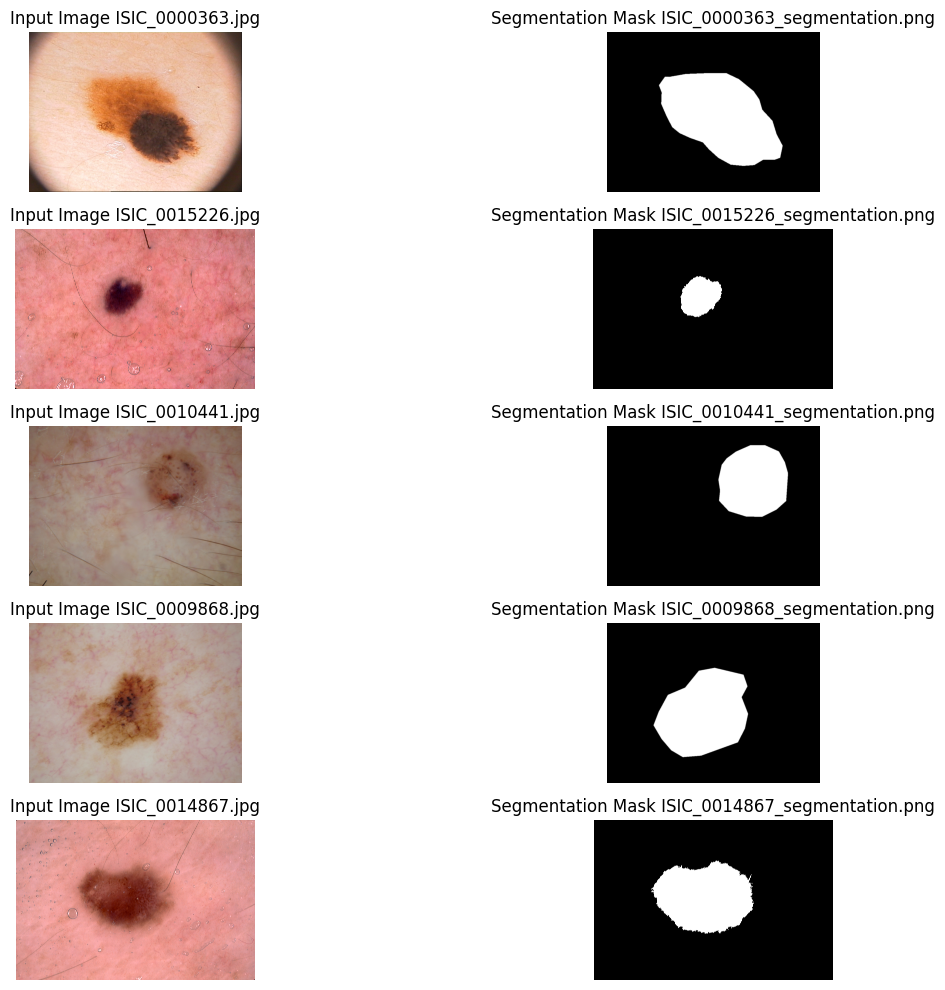

In [6]:
training_input_dir = os.path.join(dataset_path, 'ISIC2018_Task1-2_Training_Input')
training_mask_dir = os.path.join(dataset_path, 'ISIC2018_Task1_Training_GroundTruth')

input_files = os.listdir(training_input_dir)

np.random.seed(42)
sample_indices = np.random.choice(len(input_files), 2, replace=False)

# Prepare visualization
plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    filename = input_files[idx]
    
    input_image = cv2.imread(os.path.join(training_input_dir, filename))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    
    mask_filename = filename.replace('.jpg', '_segmentation.png')
    mask = cv2.imread(os.path.join(training_mask_dir, mask_filename), cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(input_image)
    plt.title(f"Input Image {filename}")
    plt.axis('off')
    
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Segmentation Mask {mask_filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
def load_images_and_masks(dataset_path, max_samples=2, target_size=(224, 224)):
    """
    Load images and masks from ISIC 2018 dataset
    
    Parameters:
    -----------
    dataset_path : str
        Root path to the ISIC 2018 dataset
    max_samples : int, optional
        Maximum number of samples to load
    target_size : tuple, optional
        Desired size for resizing images and masks
    
    Returns:
    --------
    tuple: (images, masks)
    """
    input_dir = os.path.join(dataset_path, 'ISIC2018_Task1-2_Training_Input')
    mask_dir = os.path.join(dataset_path, 'ISIC2018_Task1_Training_GroundTruth')
    input_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')][:max_samples]
    
    images = []
    masks = []
    
    for filename in input_files:
        # Read image
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read corresponding mask
        mask_filename = filename.replace('.jpg', '_segmentation.png')
        mask_path = os.path.join(mask_dir, mask_filename)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize image and mask to target size
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        images.append(img_resized)
        masks.append(mask_resized)
    
    return np.stack(images), np.stack(masks)

def visualize_augmentations(images, masks):
    """
    Visualize original and augmented images
    
    Parameters:
    -----------
    images : numpy.ndarray
        Original images
    masks : numpy.ndarray
        Corresponding segmentation masks
    """
    augmentation = A.Compose([
        A.RandomRotate90(p=1),
        A.RandomBrightnessContrast(p=1)
        ### Add more augmentations as needed
    ], additional_targets={'mask': 'mask'})
    
    num_samples = len(images)
    plt.figure(figsize=(15, 4*num_samples))
    
    for i in range(num_samples):
        # Original image and mask
        plt.subplot(num_samples, 3, 3*i+1)
        plt.imshow(images[i])
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*i+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Original Mask {i+1}')
        plt.axis('off')
        
        # Augmented image and mask
        augmented = augmentation(image=images[i], mask=masks[i])
        aug_image = augmented['image']
        aug_mask = augmented['mask']
        
        plt.subplot(num_samples, 3, 3*i+3)
        plt.imshow(aug_image)
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

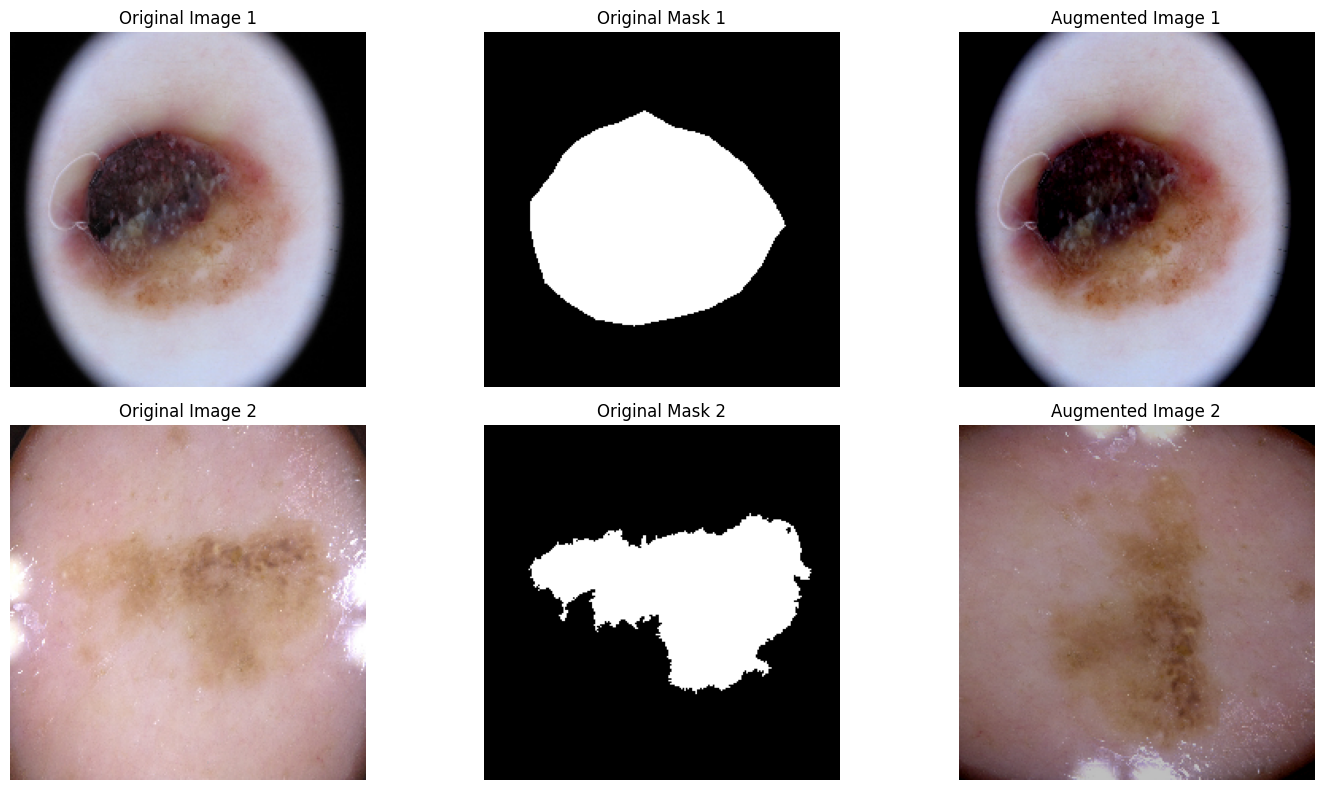

In [18]:
dataset_path = '../data/isic_2018_task1_data'
images, masks = load_images_and_masks(dataset_path)
visualize_augmentations(images, masks)

In [34]:
import os
import requests
import zipfile
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [47]:
def download_busi_dataset(save_path='../data/busi_dataset'):
    os.makedirs(save_path, exist_ok=True)
    
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()
    
    # Download dataset
    print(f"Downloading BUSI dataset to {save_path}...")
    api.dataset_download_files(
        'aryashah2k/breast-ultrasound-images-dataset', 
        path=save_path, 
        unzip=True
    )
    
    print("Download and extraction complete!")
    
    return save_path

def load_busi_dataset_info(dataset_path):
    # Dataset folder structure:
    # - Dataset_BUSI_with_GT/
    #   - benign/
    #   - malignant/
    #   - normal/
    
    busi_dir = os.path.join(dataset_path, 'Dataset_BUSI_with_GT')
    

    categories = ['benign', 'malignant', 'normal']
    category_counts = {}
    
    for category in categories:
        category_path = os.path.join(busi_dir, category)
        if os.path.exists(category_path):
            files = [f for f in os.listdir(category_path) if not '_mask' in f and f.endswith('.png')]
            category_counts[category] = len(files)
    
    sample_category = categories[0]
    sample_category_path = os.path.join(busi_dir, sample_category)
    sample_images = [f for f in os.listdir(sample_category_path) if not '_mask' in f and f.endswith('.png')]
    
    if sample_images:
        sample_image_path = os.path.join(sample_category_path, sample_images[0])
        sample_img = Image.open(sample_image_path)
        sample_image_size = sample_img.size
    else:
        sample_image_size = "No sample images found"
    
    return {
        'Total Images': sum(category_counts.values()),
        'Category Counts': category_counts,
        'Categories': list(category_counts.keys()),
        'Sample Image Size': sample_image_size,
        'Dataset Path': busi_dir
    }

def visualize_busi_samples(dataset_path, num_samples=3):
    """
    Visualize sample images from each category along with their masks
    
    Parameters:
    -----------
    dataset_path : str
        Root path to the BUSI dataset
    num_samples : int, optional
        Number of samples to visualize from each category (default is 3)
    """
    busi_dir = os.path.join(dataset_path, 'Dataset_BUSI_with_GT')
    categories = ['benign', 'malignant', 'normal']
    
    plt.figure(figsize=(15, 5*len(categories)))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(busi_dir, category)
        if not os.path.exists(category_path):
            continue
            
        image_files = [f for f in os.listdir(category_path) if not '_mask' in f and f.endswith('.png')]
        
        samples = image_files[:num_samples]
        
        for j, sample in enumerate(samples):
            image_path = os.path.join(category_path, sample)
            image = plt.imread(image_path)
            
            mask_path = os.path.join(category_path, sample.replace('.png', '_mask.png'))
            mask = None
            if os.path.exists(mask_path):
                mask = plt.imread(mask_path)
    categories = ['benign', 'malignant', 'normal']
    category_counts = {}
    
    for category in categories:
        category_path = os.path.join(busi_dir, category)
        if os.path.exists(category_path):
            files = [f for f in os.listdir(category_path) if not '_mask' in f and f.endswith('.png')]
            category_counts[category] = len(files)
    
    sample_category = categories[0]
    sample_category_path = os.path.join(busi_dir, sample_category)
    sample_images = [f for f in os.listdir(sample_category_path) if not '_mask' in f and f.endswith('.png')]
    
    if sample_images:
        sample_image_path = os.path.join(sample_category_path, sample_images[0])
        sample_img = Image.open(sample_image_path)
        sample_image_size = sample_img.size
    else:
        sample_image_size = "No sample images found"
    
    return {
        'Total Images': sum(category_counts.values()),
        'Category Counts': category_counts,
        'Categories': list(category_counts.keys()),
        'Sample Image Size': sample_image_size,
        'Dataset Path': busi_dir
    }

def visualize_busi_samples(dataset_path, num_samples=3):
    """
    Visualize sample images from each category along with their masks
    
    Parameters:
    -----------
    dataset_path : str
        Root path to the BUSI dataset
    num_samples : int, optional
        Number of samples to visualize from each category (default is 3)
    """
    busi_dir = os.path.join(dataset_path, 'Dataset_BUSI_with_GT')
    categories = ['benign', 'malignant', 'normal']
    
    plt.figure(figsize=(15, 5*len(categories)))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(busi_dir, category)
        if not os.path.exists(category_path):
            continue
            
        image_files = [f for f in os.listdir(category_path) if not '_mask' in f and f.endswith('.png')]
        
        samples = image_files[:num_samples]
        
        for j, sample in enumerate(samples):
            image_path = os.path.join(category_path, sample)
            image = plt.imread(image_path)
            
            mask_path = os.path.join(category_path, sample.replace('.png', '_mask.png'))
            mask = None
            if os.path.exists(mask_path):
                mask = plt.imread(mask_path)
            
            # Plot image
            plt.subplot(len(categories), num_samples*2, i*num_samples*2 + j*2 + 1)
            plt.imshow(image, cmap='gray')
            plt.title(f'{category} - Image')
            plt.axis('off')
            
            # Plot mask if available
            plt.subplot(len(categories), num_samples*2, i*num_samples*2 + j*2 + 2)
            if mask is not None:
                plt.imshow(mask, cmap='gray')
                plt.title(f'{category} - Mask')
            else:
                plt.title(f'{category} - No Mask')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
Download and extraction complete!

Dataset Information:
Total Images: 780
Category Counts: {'benign': 437, 'malignant': 210, 'normal': 133}
Categories: ['benign', 'malignant', 'normal']
Sample Image Size: (624, 585)
Dataset Path: ../data/busi_dataset/Dataset_BUSI_with_GT

Visualizing sample images...


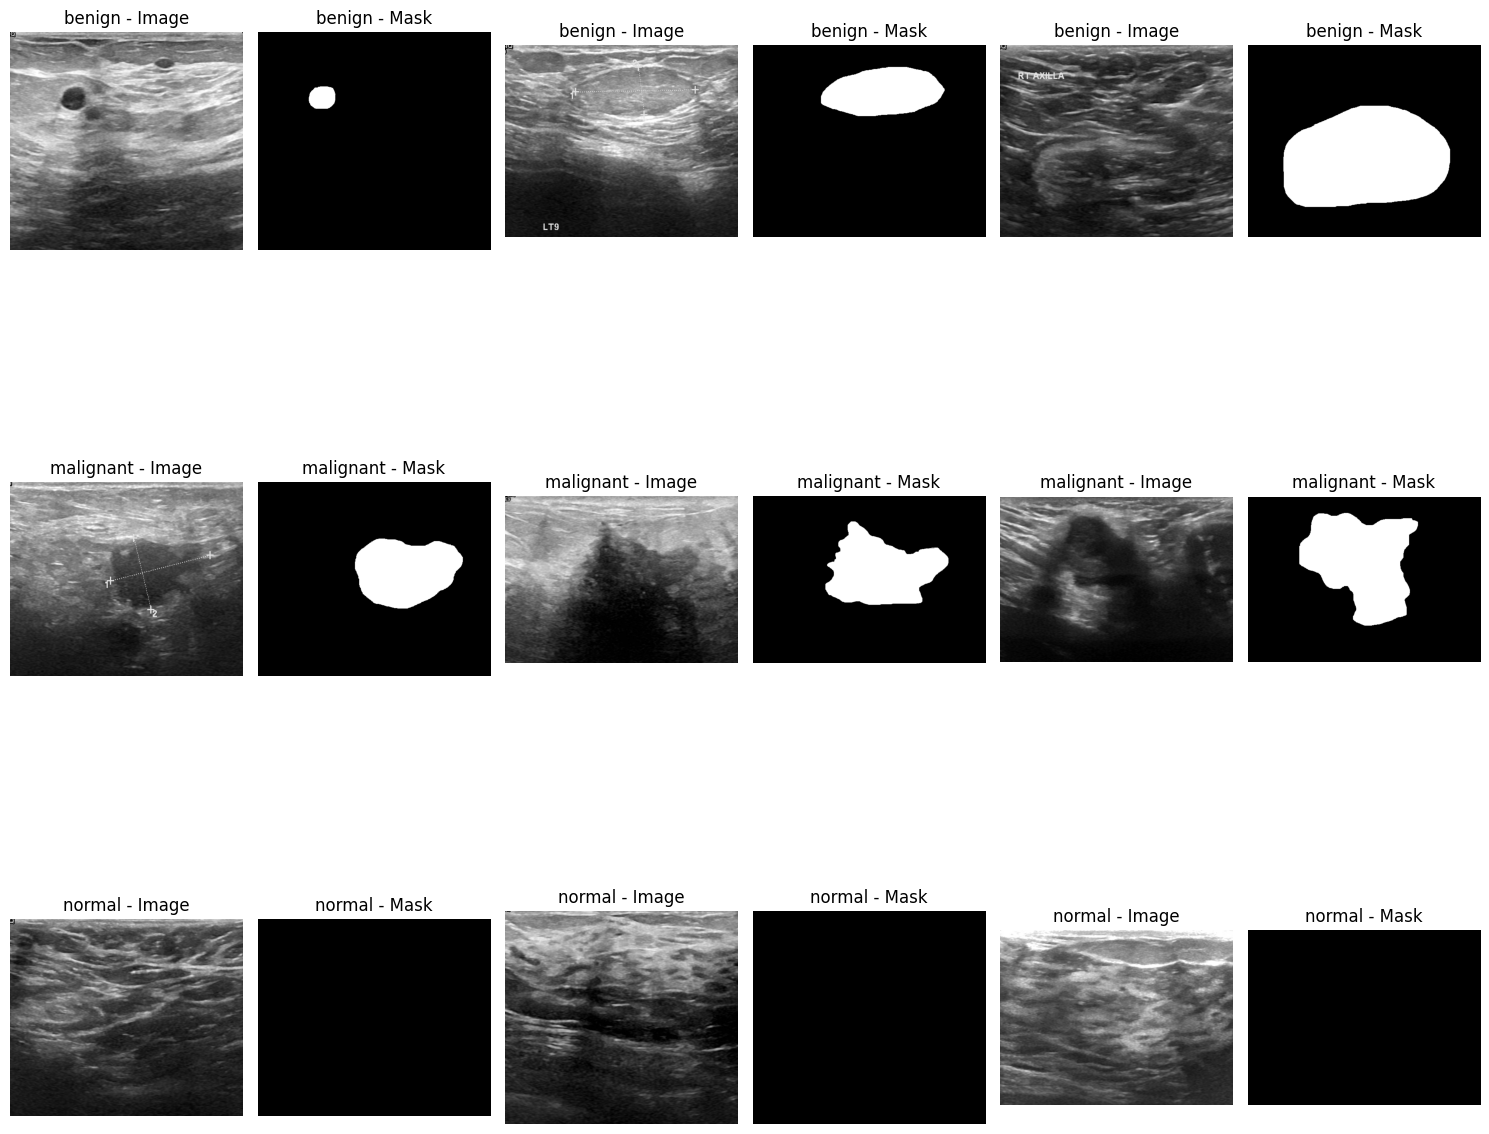

In [48]:
dataset_path = download_busi_dataset()
    
dataset_info = load_busi_dataset_info(dataset_path)
print("\nDataset Information:")
for key, value in dataset_info.items():
    print(f"{key}: {value}")

print("\nVisualizing sample images...")
visualize_busi_samples(dataset_path)